In [1]:
!pip -q install --upgrade --no-cache-dir gdown
!pip install livelossplot --quiet
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 5.5 MB/s eta 0:00:00


# Download the data

In [2]:
! wget -nc https://vizwiz.cs.colorado.edu/VizWiz_final/images/train.zip
! wget -nc https://vizwiz.cs.colorado.edu/VizWiz_final/images/val.zip
! wget -nc https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations.zip

--2023-04-25 21:44:31--  https://vizwiz.cs.colorado.edu/VizWiz_final/images/train.zip
Resolving vizwiz.cs.colorado.edu (vizwiz.cs.colorado.edu)... 198.59.7.50
Connecting to vizwiz.cs.colorado.edu (vizwiz.cs.colorado.edu)|198.59.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11298421598 (11G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  10.52G  16.4MB/s    in 36m 59s 

2023-04-25 22:21:30 (4.86 MB/s) - ‘train.zip’ saved [11298421598/11298421598]

--2023-04-25 22:21:30--  https://vizwiz.cs.colorado.edu/VizWiz_final/images/val.zip
Resolving vizwiz.cs.colorado.edu (vizwiz.cs.colorado.edu)... 198.59.7.50
Connecting to vizwiz.cs.colorado.edu (vizwiz.cs.colorado.edu)|198.59.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3488913457 (3.2G) [application/zip]
Saving to: ‘val.zip’

val.zip             100%[===================>]   3.25G  1.92MB/s    in 20m 48s 

2023-04-25 22:42:19 (2.67 MB/

In [3]:
!unzip -qq train.zip
!unzip -qq val.zip
!unzip -qq Annotations.zip

# Write a data loader

In [4]:
import torch, os, json
import matplotlib.pyplot as plt
import numpy as np
#from transformers import BertTokenizer
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPTokenizer, CLIPModel, CLIPProcessor

class vizDataset(torch.utils.data.Dataset):
    def __init__(self, split = 'val',
                 image_transform = None,
                 tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')):
        self.json_dir = './'+split+'.json'
        self.image_dir = './'+split+'/'
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.clipprocessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
        self.y = []

        # Category definitions of answer.
        self.categories = ['unanswerable','answerable']

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        self.jsondata = json.load(open(self.json_dir))
        print(' finished')
        self.metadata = []
        #process the json
        self.index=[]
        for i in range(len(self.jsondata)):
          if self.jsondata[i]['answerable']:
            image=self.jsondata[i]['image']
            question=self.jsondata[i]['question']
            answers=self.jsondata[i]['answers']
            #only confident answers with one word which is not unanswerable
            confident_answer=[a['answer'] for a in answers 
                                if a["answer_confidence"]=='yes' 
                                and a['answer']!='unanswerable'
                                and len(a['answer'].split())==1]
            try:
              answer=max(set(confident_answer), key = confident_answer.count)
              self.metadata.append([image,question,answer,i])
            except:
              continue
            

        # Pre-tokenizing all sentences.
        # See documentation for what encode_plus does and each of its parameters.
        print('Tokenizing...', end = '')
        self.tokenized_questions = list()
        self.tokenized_answers = list()
        for i in range(len(self.metadata)):
          question = self.metadata[i][1]
          answer = self.metadata[i][2]
          self.y.append(answer)
          if self.tokenizer:
            '''
            encoded_question = self.tokenizer.encode_plus(
                question, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            encoded_answer = self.tokenizer.encode_plus(
                answer, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_questions.append(encoded_question)
            self.tokenized_answers.append(encoded_answer)
            '''
        self.images_features = list()
        self.question_features = list()
        for i in range(0,len(self.metadata),256):
          if i %1024==0:
            print('processing:',i)
          image=[]
          question=[]
          for j in range(i,min(i+ 256, len(self.metadata))):
            question.append(self.metadata[j][1])
            filename = self.metadata[j][0]
            img_path = self.image_dir+filename
            image.append(Image.open(img_path).convert('RGB'))
          question_tokens = self.clipprocessor(
              text=question,
              padding=True,
              images=None,
              return_tensors='pt').to('cuda')
          question_embadding = self.clipmodel.get_text_features(**question_tokens).detach().cpu().numpy()
          image_preproccesed = self.clipprocessor(
              text=None,
              images=image,
              return_tensors='pt'
              )['pixel_values'].to('cuda')
          image_embadding =self.clipmodel.get_image_features(image_preproccesed).detach().cpu().numpy()
          self.question_features.append(question_embadding)
          self.images_features.append(image_embadding)
        self.question_features=np.concatenate(self.question_features)
        self.images_features=np.concatenate(self.images_features)
        print(self.images_features.shape)


        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        '''
        filename, question, answer, jsonind = self.metadata[index]
        img_path = self.image_dir+filename
        image = Image.open(img_path).convert('RGB')
        if self.image_transform: image = self.image_transform(image)
        if self.tokenizer:
          questiontext = self.tokenized_questions[index]['input_ids'][0]
          questiontext_mask = self.tokenized_questions[index]['attention_mask'][0]
          answertext = self.tokenized_answers[index]['input_ids'][0]
          answertext_mask = self.tokenized_answers[index]['attention_mask'][0]
          images_feature = self.images_features[index]
          question_feature=self.question_features[index]
        else:
          questiontext = self.metadata[index][1]
          answertext = self.metadata[index][2]
        '''
        if self.tokenizer:
          images_feature = self.images_features[index]
          question_feature=self.question_features[index]
          #return image, questiontext, questiontext_mask, answertext, answertext_mask,images_feature,question_feature,self.y[index]
          return images_feature,question_feature,self.y[index]
        else:
          return image, questiontext, answertext

    def load_image_only(self, index: int):
        filename, question, answer, jsonind = self.metadata[index]
        img_path = self.image_dir+filename
        image = Image.open(img_path).convert('RGB')
        return image
    
    def get_processeddata(self, index: int):
        return self.metadata[index]

    def get_metadata(self, index: int):
        filename, question, answer, jsonind = self.metadata[index]
        return self.jsondata[jsonind]
    
    def get_y(self):
        return self.y
    
    def change_y(self,y):
        self.y=y
        return self.y

    def __len__(self):
        return len(self.metadata)

# Testing loader

In [5]:
# Loading the dataloader.
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])
val_data = vizDataset(split = 'val',image_transform=transform)
print('Data size: %d samples' % len(val_data))

Loading ./val.json ... finished
Tokenizing...processing: 0
processing: 1024
processing: 2048
(2419, 512)
 finished
Data size: 2419 samples


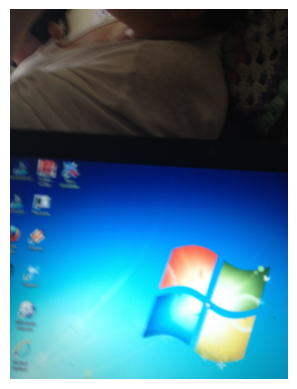

Q: I need to know specifically what is written across the screen on this computer, please.
A: desktop


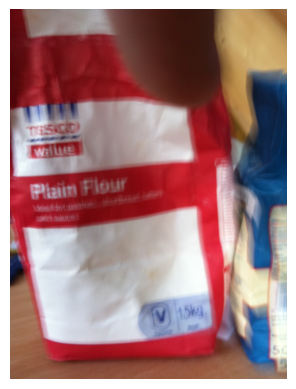

Q: Which packet contains plain flower?
A: left


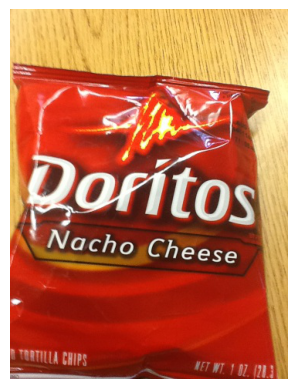

Q: What kind of chips are these?
A: doritos


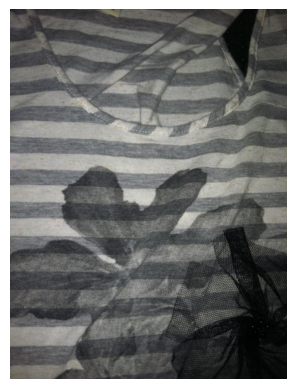

Q: What color is this shirt?
A: grey


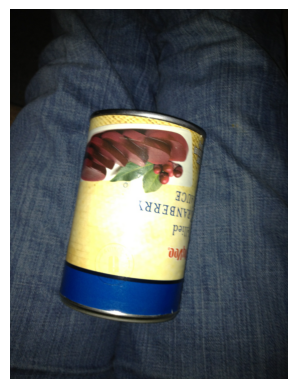

Q: Can you tell what's in this tin? 
A: cranberry


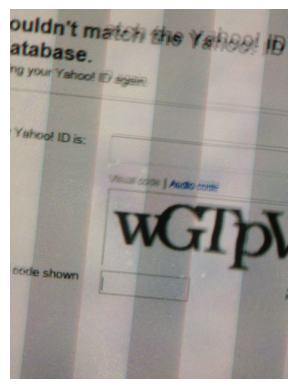

Q: Yes I need to determine the word that is in this captcha image. Thank you.
A: wftpv


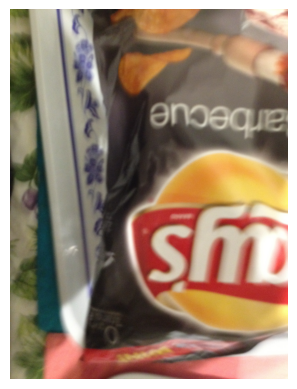

Q: What is this?  Is it barbecue or regular potato chips?
A: barbecue


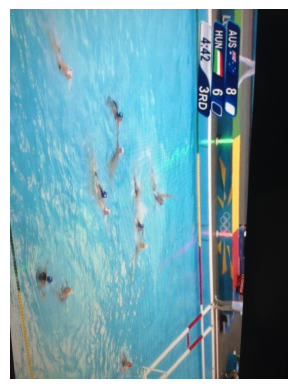

Q: Who's going to win the game?
A: austria


"\nimage, questiontext, questiontext_mask, answertext, answertext_mask, image_feature, text_feature, label = val_data[sample_questionID]\n\n# Show input image.\nplt.figure(figsize=(4,5));plt.imshow(image.numpy().T); plt.axis(False);plt.show()\n\n# Show input question (untokenized).\ntokens = val_data.tokenizer.convert_ids_to_tokens(questiontext, skip_special_tokens = True)\nprint(tokens)\nprint(val_data.tokenizer.convert_tokens_to_string(tokens))\n\n# Show input answer (untokenized).\ntokens = val_data.tokenizer.convert_ids_to_tokens(answertext, skip_special_tokens = True)\nprint(tokens)\nprint(val_data.tokenizer.convert_tokens_to_string(tokens))\n\n# You can look at other attributes for the movies on this dataset.\nmovie_metadata = val_data.get_metadata(sample_questionID)\nprint('Title: ', movie_metadata)\n\nprint(image_feature.shape, text_feature.shape)\n"

In [6]:
import random
for i in range(8):
  sample_questionID = random.randint(0, 2000)#100

  filename=val_data.get_metadata(sample_questionID)['image']
  image=Image.open('./val/'+filename).convert('RGB')
  plt.imshow(image);plt.axis(False);plt.show();
  question=val_data.get_metadata(sample_questionID)['question']
  print("Q:",question)
  answer=val_data.get_processeddata(sample_questionID)[2]
  print("A:", answer)
'''
image, questiontext, questiontext_mask, answertext, answertext_mask, image_feature, text_feature, label = val_data[sample_questionID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(image.numpy().T); plt.axis(False);plt.show()

# Show input question (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(questiontext, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show input answer (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(answertext, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_questionID)
print('Title: ', movie_metadata)

print(image_feature.shape, text_feature.shape)
'''

# Use https://huggingface.co/flax-community/clip-vision-bert-vqa-ft-6k does not work


In [7]:
#!git clone https://github.com/gchhablani/multilingual-vqa
#!mv multilingual-vqa multilingual

# Test with https://huggingface.co/dandelin/vilt-b32-finetuned-vqa works

A baseline comparison?

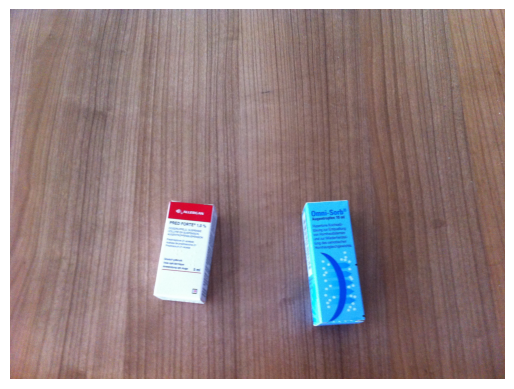

Which one is the blue one?


Predicted answer top 1 : left
Predicted answer top 2 : right
Predicted answer top 3 : middle
True answer: right


In [8]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image
import random

for i in range(1):
  sample_questionID = 1#random.randint(0, 2000)#100
  
  filename=val_data.get_metadata(sample_questionID)['image']
  image=Image.open('./val/'+filename).convert('RGB')
  plt.imshow(image);plt.axis(False);plt.show();
  question=val_data.get_metadata(sample_questionID)['question']
  print(question)

  processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
  model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
  # prepare inputs
  encoding = processor(image, question, return_tensors="pt")
  # forward pass
  outputs = model(**encoding)
  logits = outputs.logits
  values, idxs = torch.topk(logits,3)#logits.argmax(-1).item()
  for i in range(3):
    print("Predicted answer top",str(i+1),":",model.config.id2label[idxs[0][i].item()])
  answer=val_data.get_y()[sample_questionID]
  print("True answer:", val_data.get_processeddata(sample_questionID)[2])

In [9]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
correct=0
accuracy=0
k=1
for i in range(len(val_data)):
  sample_questionID = i
  
  filename=val_data.get_metadata(sample_questionID)['image']
  image=Image.open('./val/'+filename).convert('RGB')
  #image=Image.open('./val/'+filename).convert('RGB')
  #plt.imshow(image);plt.axis(False);plt.show();
  question=val_data.get_metadata(sample_questionID)['question']
  #print(question)

  # prepare inputs
  encoding = processor(image, question, return_tensors="pt")
  # forward pass
  try:
    outputs = model(**encoding)
    logits = outputs.logits
    values, idxs = torch.topk(logits,k)#logits.argmax(-1).item()
    challengecorrect=0
    for answer in val_data.get_metadata(i)['answers']:
      if model.config.id2label[idxs[0][0].item()]==answer['answer']:
        challengecorrect+=1
    accuracy+=min(1,challengecorrect/3)
    for j in range(k):
      if val_data.get_processeddata(sample_questionID)[2]==model.config.id2label[idxs[0][j].item()]:
        correct+=1
        break
  except:
    pass
print('top',k,':',100*correct/len(val_data))

Token indices sequence length is longer than the specified maximum sequence length for this model (42 > 40). Running this sequence through the model will result in indexing errors


top 1 : 25.258371227780074
challenge accuracy:  27.518258233429787


In [10]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
correct=0
k=3
for i in range(len(val_data)):
  sample_questionID = i
  
  filename=val_data.get_metadata(sample_questionID)['image']
  image=Image.open('./val/'+filename).convert('RGB')
  #image=Image.open('./val/'+filename).convert('RGB')
  #plt.imshow(image);plt.axis(False);plt.show();
  question=val_data.get_metadata(sample_questionID)['question']
  #print(question)

  # prepare inputs
  encoding = processor(image, question, return_tensors="pt")
  # forward pass
  try:
    outputs = model(**encoding)
    logits = outputs.logits
    values, idxs = torch.topk(logits,k)#logits.argmax(-1).item()
    for j in range(k):
      if val_data.get_processeddata(sample_questionID)[2]==model.config.id2label[idxs[0][j].item()]:
        correct+=1
        break
  except:
    pass
print('top',k,':',100*correct/len(val_data))

Token indices sequence length is longer than the specified maximum sequence length for this model (42 > 40). Running this sequence through the model will result in indexing errors


top 3 : 37.94956593633733


# Train Motivated by https://github.com/raunak-agarwal/clip-finetune-ade20k/blob/main/notebooks/vqa-train.ipynb 

In [11]:
train_dataset = vizDataset(split = 'train',image_transform=transform)
print('Data size: %d samples' % len(train_dataset))
importantflag=0

Loading ./train.json ... finished
Tokenizing...processing: 0
processing: 1024
processing: 2048
processing: 3072
processing: 4096
processing: 5120
processing: 6144
processing: 7168
processing: 8192
processing: 9216
processing: 10240
processing: 11264
processing: 12288
(12732, 512)
 finished
Data size: 12732 samples


In [12]:
batch_size = 256

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
if not importantflag:
  importantflag=1
  train_dataset.change_y(enc.fit_transform(np.asarray(train_dataset.get_y()).reshape(-1, 1)).todense())
  val_data.change_y(enc.transform(np.asarray(val_data.get_y()).reshape(-1, 1)).todense())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Then we can train classifier

In [13]:
import torch.nn as nn
class FeedforwardNeuralNetModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(FeedforwardNeuralNetModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, 512) 
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(512, output_dim)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    return x


In [14]:
from sklearn.preprocessing import LabelEncoder

vqa_model = FeedforwardNeuralNetModel(1024, train_dataset.get_y().shape[1])
vqa_model.to('cuda')
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(vqa_model.parameters(), lr=learning_rate)
num_epochs = 40

for epoch in range(num_epochs):
    for i, (image_feature, text_feature, label) in enumerate(train_loader):

        features = torch.cat((image_feature,text_feature),1).requires_grad_().to('cuda')
        label = label.reshape([-1,train_dataset.get_y().shape[1]]).to('cuda')

        optimizer.zero_grad()

        outputs = vqa_model(features)

        loss = criterion(outputs, label)

        loss.backward()

        # Updating parameters
        optimizer.step()
        
        
    with torch.no_grad():
        # Calculate Accuracy         
        correct = 0
        total = 0
        for j, (image_feature, text_feature, label) in enumerate(val_loader):
            features = torch.cat((image_feature,text_feature),1).to('cuda')
            outputs = vqa_model(features)

            _, predicted=outputs.data.cpu().topk(1, dim=1)

            labels_again = torch.argmax(label.reshape([-1,train_dataset.get_y().shape[1]]).cpu(), dim=1)

            total += label.size(0)

            # Total correct predictions
            if torch.cuda.is_available():
                correct += (predicted.T[0].cpu() == labels_again).sum()
            else:
                correct += (predicted == label).sum()

        accuracy = 100 * correct.item() / total

        # Print Loss
        if epoch%5==0:
          print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

Epoch: 0. Loss: 5.701929775324274. Accuracy: 15.378255477470029
Epoch: 5. Loss: 1.9268606121508167. Accuracy: 29.185613890037207
Epoch: 10. Loss: 0.5872815318635982. Accuracy: 31.91401405539479
Epoch: 15. Loss: 0.26890118934333007. Accuracy: 31.996692848284415
Epoch: 20. Loss: 0.15377217981152538. Accuracy: 32.120711037618854
Epoch: 25. Loss: 0.07841165922055804. Accuracy: 31.70731707317073
Epoch: 30. Loss: 0.06471797320782667. Accuracy: 31.376601901612236
Epoch: 35. Loss: 0.028658892445990087. Accuracy: 32.49276560562216


In [ ]:
#challenge accuracy
#top1 accuracy
predicted_total=[]
label_total=[]
k=1
with torch.no_grad():
  for j, (image_feature, text_feature, label) in enumerate(val_loader):
    features = torch.cat((image_feature,text_feature),1).to('cuda')
    outputs = vqa_model(features)
    
    _, predicted=outputs.data.cpu().topk(k, dim=1)

    label=label.reshape([-1,train_dataset.get_y().shape[1]]).cpu()
    
    labels_again = torch.argmax(label, dim=1)
    predicted_total.append(outputs.data.cpu().numpy())
    label_total.append(label.numpy())

predicted_total=np.concatenate(predicted_total)
label_total=np.concatenate(label_total)
predicted_total=enc.inverse_transform(predicted_total)
label_total=enc.inverse_transform(label_total)
accuracy=0
for i in range(len(val_data)):
  correct=0
  for answer in val_data.get_metadata(i)['answers']:
    if predicted_total[i]==answer['answer']:
      correct+=1
  accuracy+=min(1,correct/3)
accuracy=accuracy/len(val_data)*100
print('Top-1 accuracy is:',accuracy)

In [16]:
#top3 accuracy
predicted_total=[]
predicted_k=[]
label_total=[]
k=3
with torch.no_grad():
  # Calculate Accuracy
  correct = 0
  total = 0
  for j, (image_feature, text_feature, label) in enumerate(val_loader):
    features = torch.cat((image_feature,text_feature),1).to('cuda')
    outputs = vqa_model(features)
    
    _, predicted=outputs.data.cpu().topk(k, dim=1)

    label=label.reshape([-1,train_dataset.get_y().shape[1]]).cpu()
    
    labels_again = torch.argmax(label, dim=1)
    
    #total += label.size(0)
    predicted_total.append(outputs.data.cpu().numpy())
    label_total.append(label.numpy())
    predicted_k.append(predicted)
    # Total correct predictions
    for counter, alabel in enumerate(labels_again.cpu()):
      if sum(label[counter])!=0:
        total +=1
        correct+=alabel in predicted.cpu()[counter]
  accuracy = 100 * correct/ total
print(total)
print('Top',k,' accuracy is:',accuracy)
print('baseline maybe: 57.7%?')
predicted_total=np.concatenate(predicted_total)
label_total=np.concatenate(label_total)
predicted_k=np.concatenate(predicted_k)
predicted_total=enc.inverse_transform(predicted_total)
label_total=enc.inverse_transform(label_total)
print(label_total[:10].T)
print(predicted_total[:10].T)

1973
Top 3  accuracy is: 57.62797769893563
baseline maybe: 57.7%?
[['no' 'right' 'nothing' 'white' 'left' None 'medicine' 'no' None 'pills']]
[['no' 'right' 'light' 'white' 'right' 'laptop' 'no' 'no' 'cloudy'
  'citalopram']]


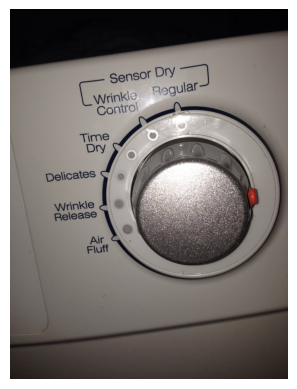

What is the setting on this dryer?
true answer: ['off']
predict answer: ['regular']
top 3 : regular
top 3 : normal
top 3 : 350


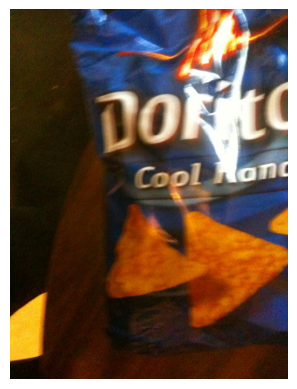

what is this please?
true answer: ['doritos']
predict answer: ['chips']
top 3 : chips
top 3 : crackers
top 3 : doritos


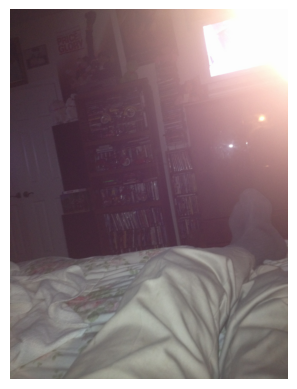

What is this?
true answer: ['bed']
predict answer: ['television']
top 3 : television
top 3 : tv
top 3 : lamp


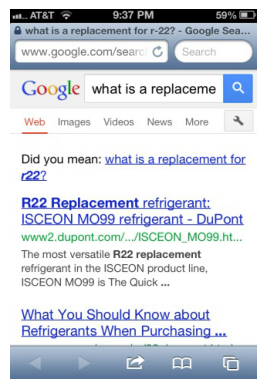

What is the replacement for R22?
true answer: [None]
predict answer: ['no']
top 3 : no
top 3 : yes
top 3 : 0


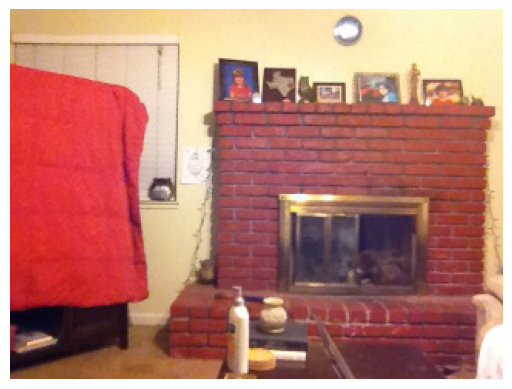

What's this?
true answer: ['fireplace']
predict answer: ['chair']
top 3 : chair
top 3 : red
top 3 : doorway


In [17]:
import random
for i in range(5):
  valindex = random.randint(0, len(val_data))
  filename=val_data.get_metadata(valindex)['image']
  plt.imshow(Image.open('./val/'+filename).convert('RGB'));plt.axis(False);plt.show();
  print(val_data.get_metadata(valindex)['question'])
  print('true answer:',label_total[valindex])
  print('predict answer:',predicted_total[valindex])
  for j in range(k):
    print('top',k,':',enc.categories_[0][predicted_k[valindex][j]])

In [18]:
torch.save(vqa_model.state_dict(), 'best_model_so_far.pth') 

In [19]:
from google.colab import files
files.download('best_model_so_far.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>